In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, auc, roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from data_repository import DataRepository
from model_training_ultils import ModelMemCalculation
from model_training_ultils import ModelEvaluationUltis

# Import data

In [2]:
mem_cal = ModelMemCalculation()
evaludation_tool = ModelEvaluationUltis()

In [3]:
data_repo = DataRepository("../.env")
#Clean data
train_ampls, y_train, validation_ampls, y_validation, test_ampls, y_test = data_repo.load_fft_data(clean_data=True)

In [4]:
print(f"Train dataset: X: {train_ampls.shape}, y: {y_train.shape}")
print(f"Validation dataset: X: {validation_ampls.shape}, y: {y_validation.shape}")
print(f"Test dataset: X: {test_ampls.shape}, y: {y_test.shape}")

Train dataset: X: (8188, 4501), y: (8188,)
Validation dataset: X: (1123, 4501), y: (1123,)
Test dataset: X: (2012, 4501), y: (2012,)


__Label encoder__

In [5]:
# Chuyển đổi danh sách labels thành mã số
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_validation = label_encoder.transform(y_validation)
y_test = label_encoder.transform(y_test)

In [6]:
print(list(label_encoder.classes_))
print(label_encoder.transform(list(label_encoder.classes_)))

['error', 'normal', 'overcurrent', 'overheating', 'zero']
[0 1 2 3 4]


# Feature selection

## Finding top 50 highest amplitudes

In [7]:
def find_top_k_indices(amplitudes, k):
    # Get the indices of the top 50 elements
    top_k_indices = np.argsort(amplitudes)[-k:][::-1]
    highest_ampls = amplitudes[top_k_indices]
    return highest_ampls

def get_x_by_top_ampls(k, ampls):
    X = []
    for ampl in ampls:
        X.append(find_top_k_indices(amplitudes=ampl, k=k))
    return np.array(X)

__Optimal k__
- k SVM = 201
- k XgBoost = 2301
- k RF = 151

In [8]:
X_train_SVM = get_x_by_top_ampls(k=201, ampls=train_ampls)
X_validation_SVM = get_x_by_top_ampls(k=201, ampls=validation_ampls)
X_test_SVM = get_x_by_top_ampls(k=201, ampls=test_ampls)

X_train_RF = get_x_by_top_ampls(k=151, ampls=train_ampls)
X_validation_RF = get_x_by_top_ampls(k=151, ampls=validation_ampls)
X_test_RF = get_x_by_top_ampls(k=151, ampls=test_ampls)

X_train_XgBoost = get_x_by_top_ampls(k=2301, ampls=train_ampls)
X_validation_XgBoost = get_x_by_top_ampls(k=2301, ampls=validation_ampls)
X_test_XgBoost = get_x_by_top_ampls(k=2301, ampls=test_ampls)

In [9]:
print(X_train_SVM.shape, X_validation_SVM.shape, X_test_SVM.shape)
print(X_train_RF.shape, X_validation_RF.shape, X_test_RF.shape)
print(X_train_XgBoost.shape, X_validation_XgBoost.shape, X_test_XgBoost.shape)

(8188, 201) (1123, 201) (2012, 201)
(8188, 151) (1123, 151) (2012, 151)
(8188, 2301) (1123, 2301) (2012, 2301)


# Model training

## SVM

### Xây dựng mô hình

In [10]:
from sklearn.svm import SVC
svm_fft = SVC(kernel='rbf', random_state=42, probability=True)
svm_fft.fit(X_train_SVM, y_train)

SVC(probability=True, random_state=42)

In [11]:
svm_memory_size = mem_cal.bytes_to_kb(mem_cal.deep_sizeof(svm_fft)) 
print("Instance state: {} KB".format(svm_memory_size))

Instance state: 8310.002 KB


In [12]:
svm_y_pred_val = svm_fft.predict(X_validation_SVM)
svm_y_pred_proba_val = svm_fft.predict_proba(X_validation_SVM)

              precision    recall  f1-score   support

       error       0.93      0.76      0.84       232
      normal       0.99      0.98      0.98       228
 overcurrent       0.98      1.00      0.99       220
 overheating       0.83      0.96      0.89       200
        zero       0.93      0.97      0.95       243

    accuracy                           0.93      1123
   macro avg       0.93      0.93      0.93      1123
weighted avg       0.93      0.93      0.93      1123


Custom reports
Precision: 0.9320129822331911
Recall: 0.932753810878836
Accuracy: 0.931433659839715
F1-Score (Macro): 0.9296343317520442
Macro-average AUC (SVM): 0.9964593509072464


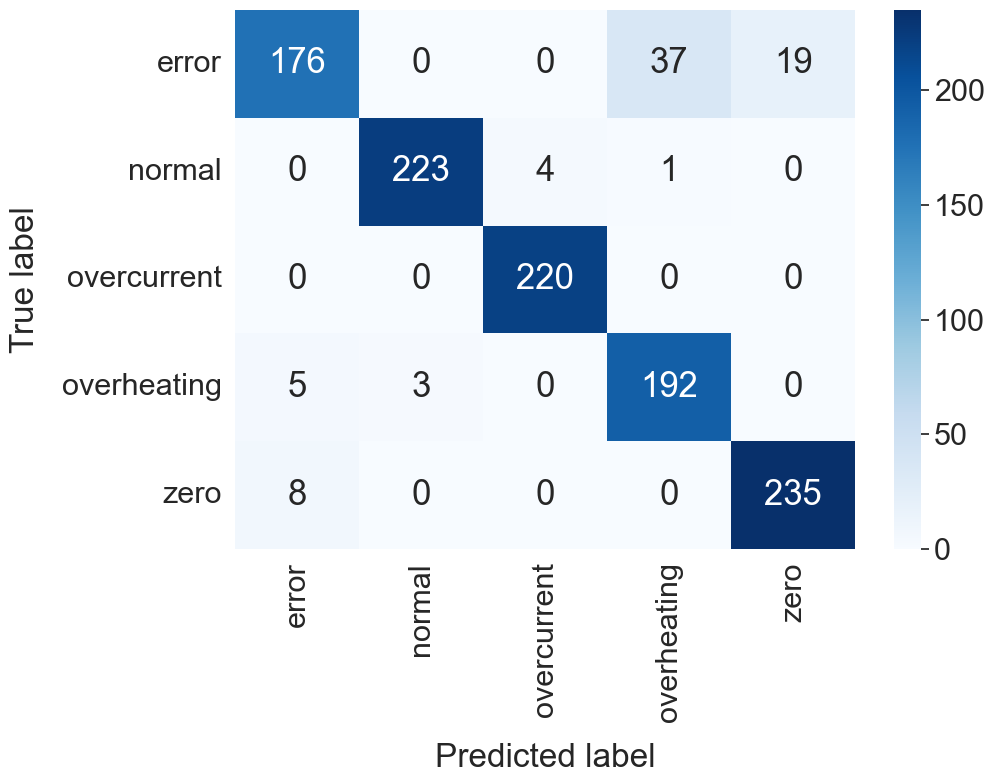

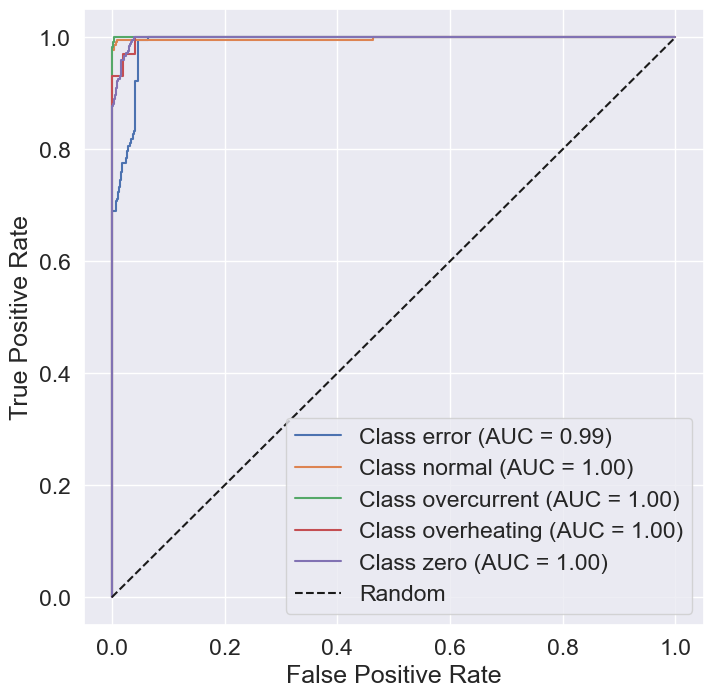

In [13]:
svm_conf_val = evaludation_tool.evaluate_and_print_results(y_pred=svm_y_pred_val, y_pred_proba=svm_y_pred_proba_val, y_test=y_validation, label_encoder=label_encoder) 
evaludation_tool.plot_conf_matrix(svm_conf_val)
evaludation_tool.plot_auc_curve(y_test=y_validation, y_pred_proba=svm_y_pred_proba_val, label_encoder=label_encoder)

In [14]:
svm_y_pred = svm_fft.predict(X_test_SVM)
svm_y_pred_proba = svm_fft.predict_proba(X_test_SVM)

              precision    recall  f1-score   support

       error       0.94      0.78      0.85       413
      normal       0.97      1.00      0.98       390
 overcurrent       1.00      1.00      1.00       421
 overheating       0.85      0.95      0.90       379
        zero       0.93      0.96      0.95       409

    accuracy                           0.94      2012
   macro avg       0.94      0.94      0.94      2012
weighted avg       0.94      0.94      0.94      2012


Custom reports
Precision: 0.9370691445409045
Recall: 0.9375303298420642
Accuracy: 0.9368787276341949
F1-Score (Macro): 0.9352930430675803
Macro-average AUC (SVM): 0.9979846890860562


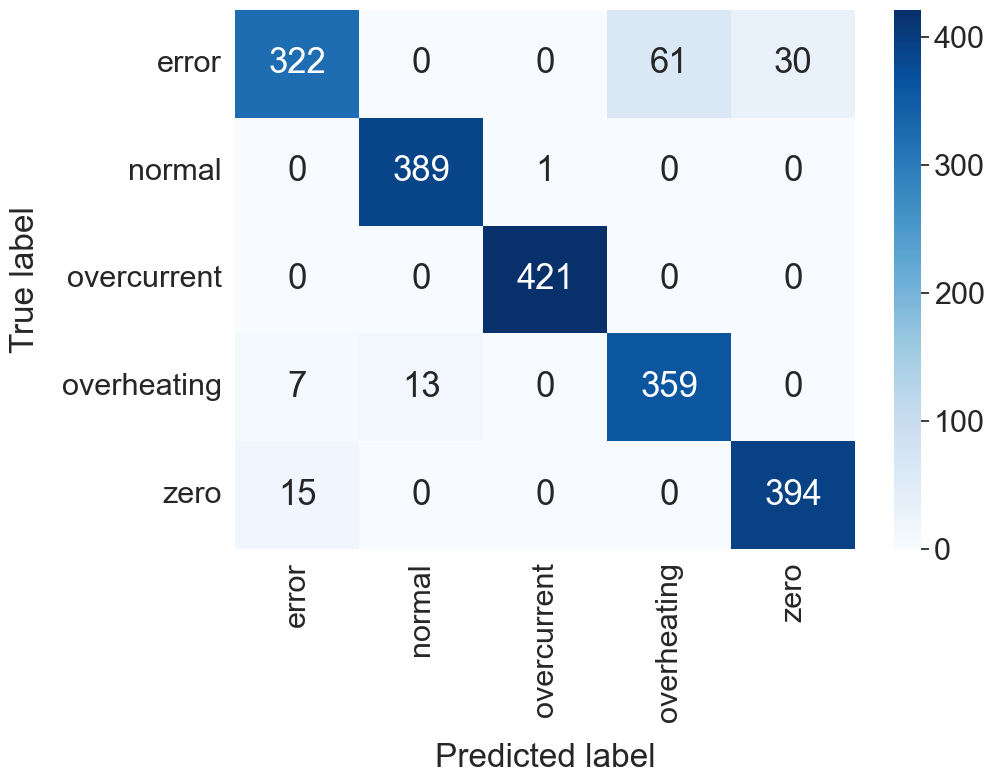

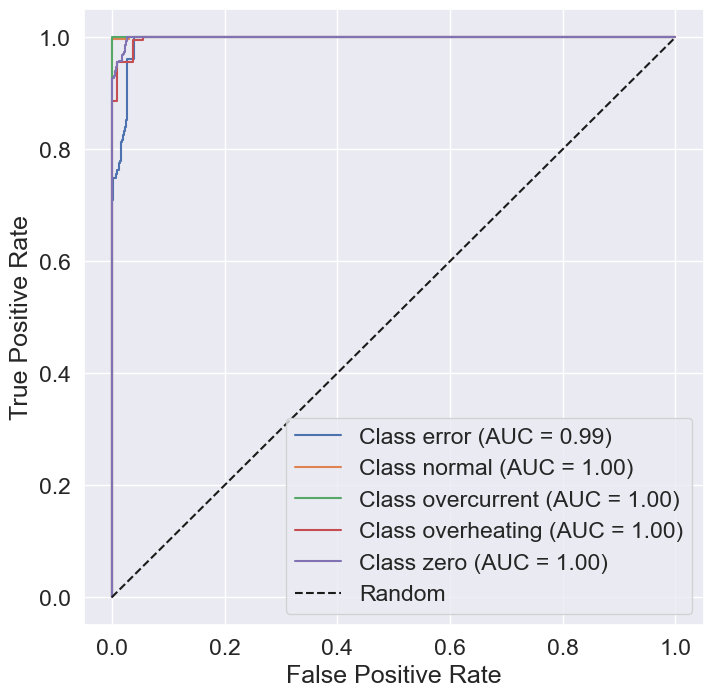

In [15]:
svm_conf = evaludation_tool.evaluate_and_print_results(y_pred=svm_y_pred, y_pred_proba=svm_y_pred_proba, y_test=y_test, label_encoder=label_encoder) 
evaludation_tool.plot_conf_matrix(svm_conf)
evaludation_tool.plot_auc_curve(y_test=y_test, y_pred_proba=svm_y_pred_proba, label_encoder=label_encoder)

## Random Forest

### Xây dựng mô hình

In [16]:
# Tạo mô hình RF
from sklearn.ensemble import RandomForestClassifier
rf_fft = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
rf_fft.fit(X_train_RF, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [17]:
rf_memory_size = mem_cal.bytes_to_kb(mem_cal.deep_sizeof(rf_fft, verbose=True))
print("Instance state: {} kB".format(rf_memory_size))

| Attribute | `type(v)` | `deep_sizeof(v)` |
|---|---|---|
| _abc_impl | <class '_abc._abc_data'> | 16 |
| _estimator_type | <class 'str'> | 59 |
| _parameter_constraints | <class 'dict'> | 16 |
| _required_parameters | <class 'list'> | 40 |
| base_estimator | <class 'str'> | 59 |
| bootstrap | <class 'bool'> | 28 |
| ccp_alpha | <class 'float'> | 24 |
| class_weight | <class 'NoneType'> | 16 |
| classes_ | <class 'numpy.ndarray'> | 192 |
| criterion | <class 'str'> | 56 |
| estimator | <class 'sklearn.tree._classes.DecisionTreeClassifier'> | 421 |
| estimator_ | <class 'sklearn.tree._classes.DecisionTreeClassifier'> | 421 |
| estimator_params | <class 'tuple'> | 657 |
| estimators_ | <class 'list'> | 7247846 |
| max_depth | <class 'NoneType'> | 16 |
| max_features | <class 'str'> | 53 |
| max_leaf_nodes | <class 'NoneType'> | 16 |
| max_samples | <class 'NoneType'> | 16 |
| min_impurity_decrease | <class 'float'> | 24 |
| min_samples_leaf | <class 'int'> | 28 |
| min_samples_split | <

/home/mrcong/miniconda3/envs/tf-wsl/lib/python3.11/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `base_estimator_` was deprecated in version 1.2 and will be removed in 1.4. Use `estimator_` instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
rf_y_pred_val = rf_fft.predict(X_validation_RF)
rf_y_pred_proba_val = rf_fft.predict_proba(X_validation_RF)

              precision    recall  f1-score   support

       error       0.90      0.94      0.92       232
      normal       0.98      0.96      0.97       228
 overcurrent       0.98      1.00      0.99       220
 overheating       0.99      0.99      0.99       200
        zero       0.95      0.91      0.93       243

    accuracy                           0.96      1123
   macro avg       0.96      0.96      0.96      1123
weighted avg       0.96      0.96      0.96      1123


Custom reports
Precision: 0.9617592288511829
Recall: 0.9618455184363635
Accuracy: 0.9599287622439893
F1-Score (Macro): 0.9615726742112397
Macro-average AUC (SVM): 0.9970063325102754


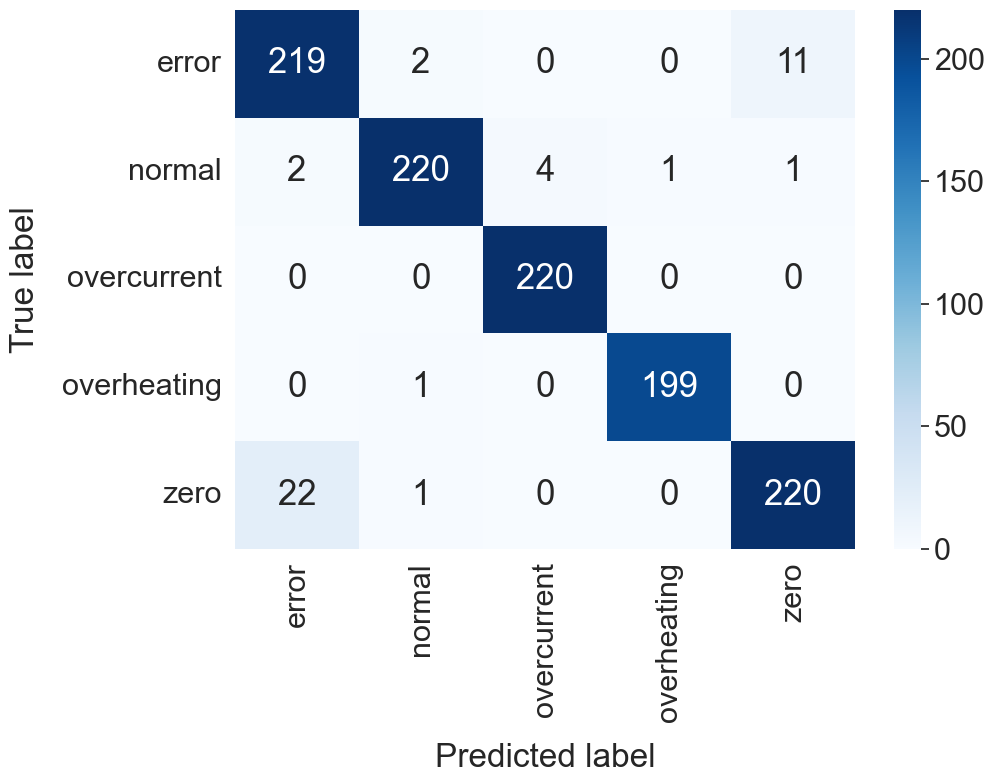

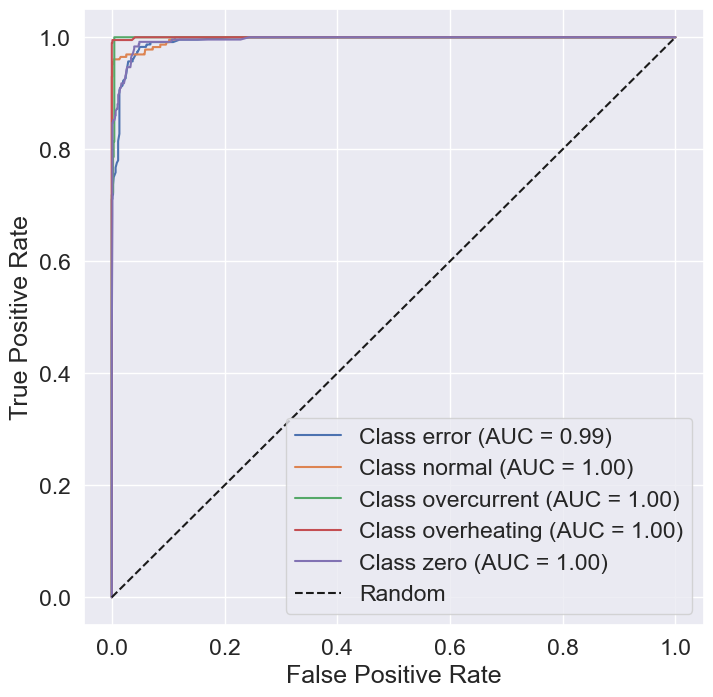

In [19]:
rf_val_cm = evaludation_tool.evaluate_and_print_results(y_pred=rf_y_pred_val, y_pred_proba=rf_y_pred_proba_val, y_test=y_validation, label_encoder=label_encoder)
evaludation_tool.plot_conf_matrix(conf_matrix=rf_val_cm)
evaludation_tool.plot_auc_curve(y_pred_proba=rf_y_pred_proba_val, y_test=y_validation, label_encoder=label_encoder)

In [20]:
rf_y_pred = rf_fft.predict(X_test_RF)
rf_y_pred_proba = rf_fft.predict_proba(X_test_RF)

              precision    recall  f1-score   support

       error       0.94      0.92      0.93       413
      normal       0.94      0.97      0.95       390
 overcurrent       1.00      0.99      0.99       421
 overheating       0.99      0.99      0.99       379
        zero       0.95      0.94      0.95       409

    accuracy                           0.96      2012
   macro avg       0.96      0.96      0.96      2012
weighted avg       0.96      0.96      0.96      2012


Custom reports
Precision: 0.9617719300390103
Recall: 0.9621617073648954
Accuracy: 0.9617296222664016
F1-Score (Macro): 0.9618508509486912
Macro-average AUC (SVM): 0.9982015178677811


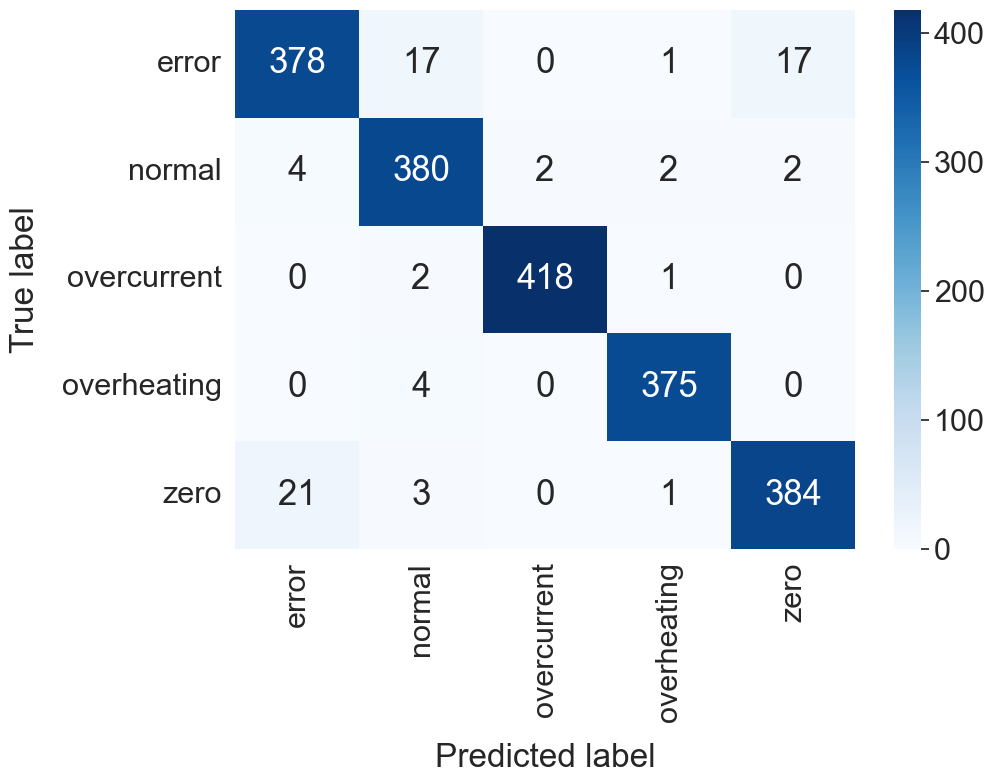

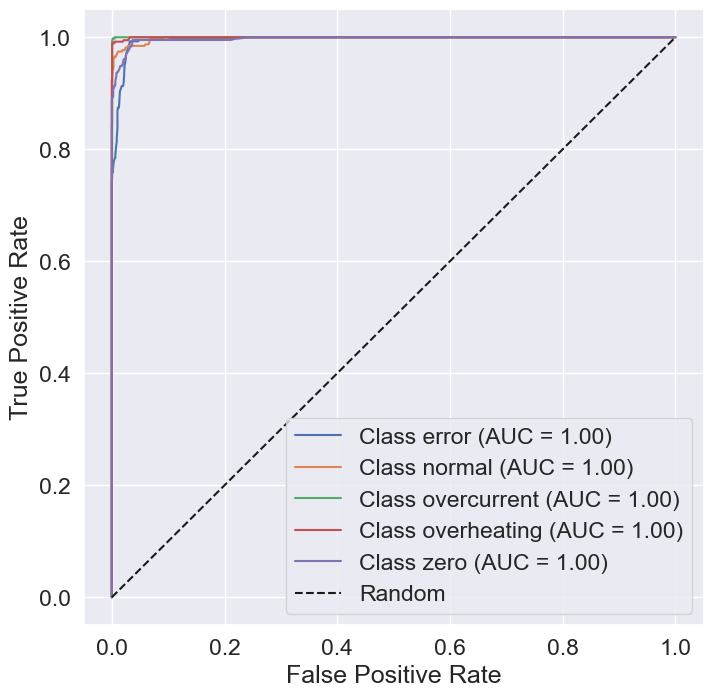

In [21]:
rf_cm = evaludation_tool.evaluate_and_print_results(y_pred=rf_y_pred, y_pred_proba=rf_y_pred_proba, y_test=y_test, label_encoder=label_encoder)
evaludation_tool.plot_conf_matrix(conf_matrix=rf_cm)
evaludation_tool.plot_auc_curve(y_pred_proba=rf_y_pred_proba, y_test=y_test, label_encoder=label_encoder)

## XgBoost

### Xây dựng mô hình

In [22]:
from xgboost import XGBClassifier
xgboost_fft = XGBClassifier(objective='binary:logistic', tree_method="gpu_hist")
xgboost_fft.fit(X_train_XgBoost, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [23]:
xgb_memory_size = mem_cal.bytes_to_kb(mem_cal.deep_sizeof(xgboost_fft, verbose=True, with_overhead=True)) 
print("Instance state: {} kB".format(xgb_memory_size))

| Attribute | `type(v)` | `deep_sizeof(v)` |
|---|---|---|
| _Booster | <class 'xgboost.core.Booster'> | 226 |
| _estimator_type | <class 'str'> | 59 |
| base_score | <class 'NoneType'> | 16 |
| booster | <class 'NoneType'> | 16 |
| callbacks | <class 'NoneType'> | 16 |
| classes_ | <class 'numpy.ndarray'> | 192 |
| colsample_bylevel | <class 'NoneType'> | 16 |
| colsample_bynode | <class 'NoneType'> | 16 |
| colsample_bytree | <class 'NoneType'> | 16 |
| early_stopping_rounds | <class 'NoneType'> | 16 |
| enable_categorical | <class 'bool'> | 28 |
| eval_metric | <class 'NoneType'> | 16 |
| feature_types | <class 'NoneType'> | 16 |
| gamma | <class 'NoneType'> | 16 |
| gpu_id | <class 'NoneType'> | 16 |
| grow_policy | <class 'NoneType'> | 16 |
| importance_type | <class 'NoneType'> | 16 |
| interaction_constraints | <class 'NoneType'> | 16 |
| learning_rate | <class 'NoneType'> | 16 |
| max_bin | <class 'NoneType'> | 16 |
| max_cat_threshold | <class 'NoneType'> | 16 |
| max_cat_to_o

#### Validation set

In [24]:
xgb_y_pred_val = xgboost_fft.predict(X_validation_XgBoost)
xgb_y_pred_proba_val = xgboost_fft.predict_proba(X_validation_XgBoost)

              precision    recall  f1-score   support

       error       0.91      0.96      0.94       232
      normal       1.00      0.98      0.99       228
 overcurrent       0.98      1.00      0.99       220
 overheating       1.00      1.00      1.00       200
        zero       0.96      0.91      0.93       243

    accuracy                           0.97      1123
   macro avg       0.97      0.97      0.97      1123
weighted avg       0.97      0.97      0.97      1123


Custom reports
Precision: 0.9696482759229583
Recall: 0.9697484185132904
Accuracy: 0.9679430097951914
F1-Score (Macro): 0.9693764242066802
Macro-average AUC (SVM): 0.9983001933172895


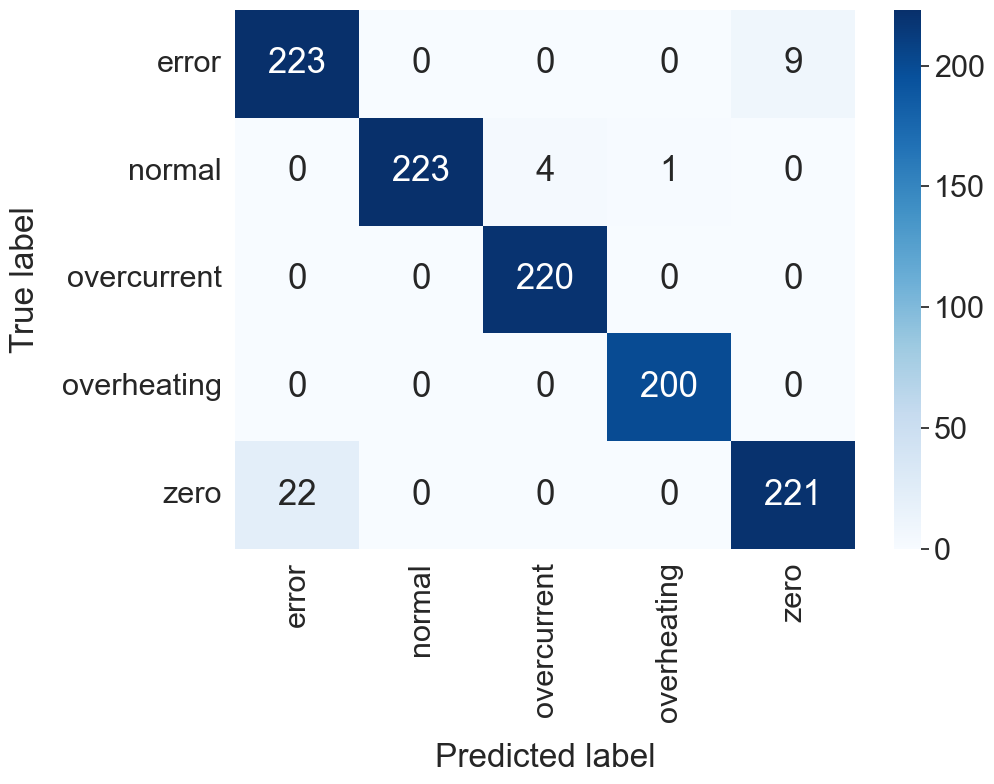

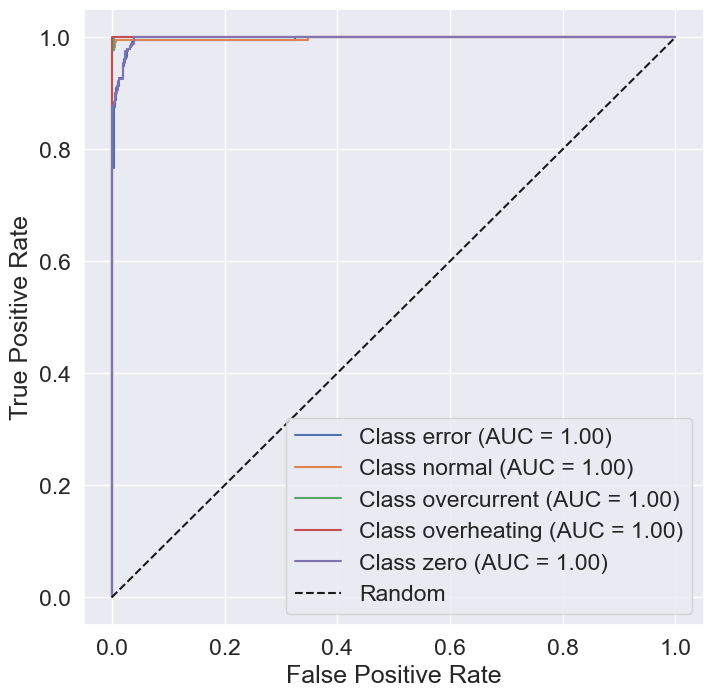

In [25]:
xgb_val_cm = evaludation_tool.evaluate_and_print_results(y_pred=xgb_y_pred_val, y_pred_proba=xgb_y_pred_proba_val, y_test=y_validation, label_encoder=label_encoder)
evaludation_tool.plot_conf_matrix(conf_matrix=xgb_val_cm)
evaludation_tool.plot_auc_curve(y_pred_proba=xgb_y_pred_proba_val, y_test=y_validation, label_encoder=label_encoder)

#### Test set

In [26]:
xgb_y_pred = xgboost_fft.predict(X_test_XgBoost)
xgb_y_pred_proba = xgboost_fft.predict_proba(X_test_XgBoost)

              precision    recall  f1-score   support

       error       0.95      0.95      0.95       413
      normal       0.98      1.00      0.99       390
 overcurrent       1.00      0.98      0.99       421
 overheating       1.00      1.00      1.00       379
        zero       0.95      0.95      0.95       409

    accuracy                           0.98      2012
   macro avg       0.98      0.98      0.98      2012
weighted avg       0.98      0.98      0.98      2012


Custom reports
Precision: 0.9755522992872392
Recall: 0.9757185875757377
Accuracy: 0.9751491053677932
F1-Score (Macro): 0.9756114558089539
Macro-average AUC (SVM): 0.9994188684687497


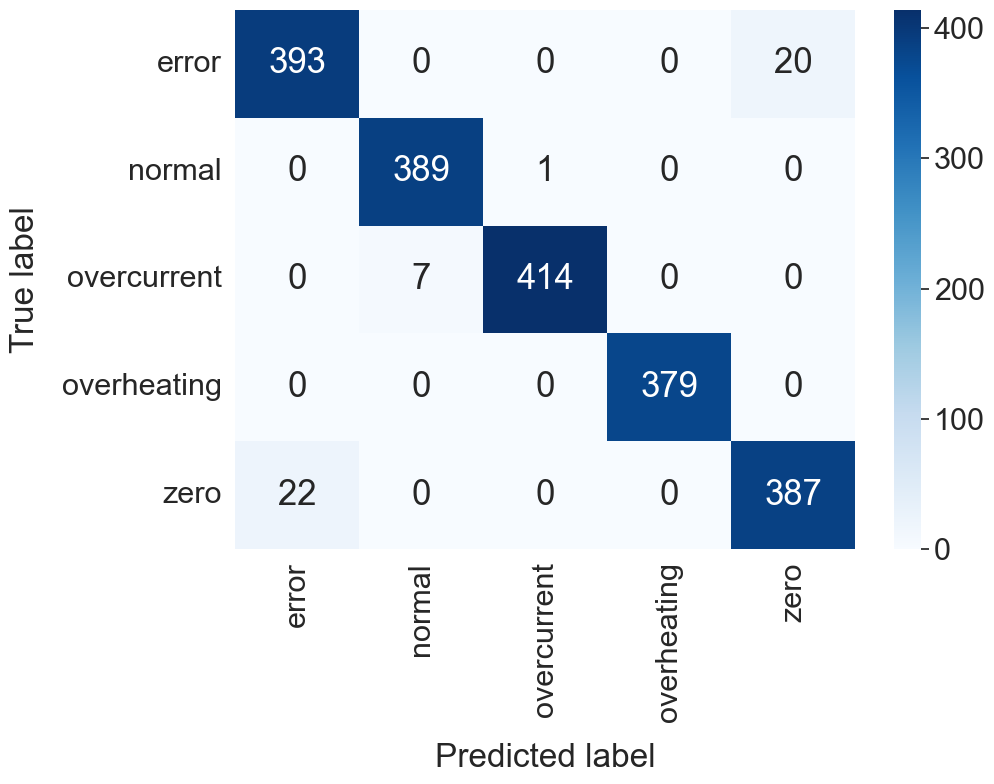

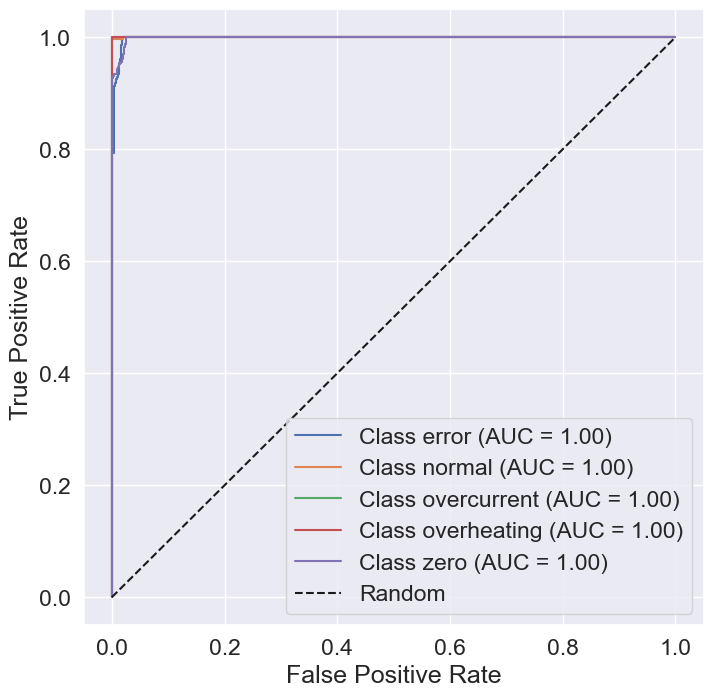

In [27]:
xgb_test_cm_test = evaludation_tool.evaluate_and_print_results(y_pred=xgb_y_pred, y_pred_proba=xgb_y_pred_proba, y_test=y_test, label_encoder=label_encoder)
evaludation_tool.plot_conf_matrix(conf_matrix=xgb_test_cm_test)
evaludation_tool.plot_auc_curve(y_pred_proba=xgb_y_pred_proba, y_test=y_test, label_encoder=label_encoder)

# Overfitting check

In [28]:
svm_train_accuracy = accuracy_score(y_pred=svm_fft.predict(X_train_SVM), y_true=y_train)
svm_validation_accuracy = accuracy_score(y_pred=svm_y_pred_val, y_true=y_validation) 
svm_test_accuracy = accuracy_score(y_pred=svm_y_pred, y_true=y_test)
print(f"SVM train error: {1-svm_train_accuracy}, validation error: {1-svm_validation_accuracy}, test error: {1-svm_test_accuracy}")

SVM train error: 0.0589887640449438, validation error: 0.06856634016028496, test error: 0.06312127236580511


In [44]:
svm_y_pred_val

array([3, 0, 0, ..., 4, 4, 4])

In [63]:
check = [rf_fft.predict(X_train_RF) == y_train][0]
np.count_nonzero(check == False)

5

In [69]:
1- accuracy_score(y_pred=rf_fft.predict(X_train_RF), y_true=y_train)

0.0006106497313140835

In [72]:
np.count_nonzero((rf_fft.predict(X_train_RF) == y_train) == False) 

5

In [65]:
rf_train_accuracy = accuracy_score(y_pred=rf_fft.predict(X_train_RF), y_true=y_train)
rf_val_ac = accuracy_score(y_pred=rf_y_pred_val, y_true=y_validation)
rf_test_ac = accuracy_score(y_pred=rf_y_pred, y_true=y_test)
print(f"RF train error: {1-rf_train_accuracy}, validation error: {1-rf_val_ac}, test error: {1-rf_test_ac}")

RF train error: 0.0006106497313140835, validation error: 0.040071237756010736, test error: 0.038270377733598426


In [30]:
xgb_train_accuracy = accuracy_score(y_pred=xgboost_fft.predict(X_train_XgBoost), y_true=y_train)
xgb_val_ac = accuracy_score(y_pred=xgb_y_pred_val, y_true=y_validation)
xgb_test_ac = accuracy_score(y_pred=xgb_y_pred, y_true=y_test)
print(f"XgBoost train error: {1-xgb_train_accuracy}, SVM validation error: {1-xgb_val_ac}, SVM test error: {1-xgb_test_ac}")

XgBoost train error: 0.0006106497313140835, SVM validation error: 0.032056990204808566, SVM test error: 0.0248508946322068


# Khảo sát K best ở đâu

In [31]:
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif
# from tqdm import tqdm

# svm_acs, svm_f1s, svm_aucs = [], [], []
# rf_acs, rf_f1s, rf_aucs = [], [], []
# xgb_acs, xgb_f1s, xgb_aucs = [], [], []
# k_arr = []

# for k in range(1, train_ampls.shape[1]+1, 50):
#     # Feature selection
#     print(f"[+] Working with {k} features")
#     #Using top 50 ampls
#     k_arr.append(k)
#     X_train = get_x_by_top_ampls(k=k, ampls=train_ampls)
#     X_validation = get_x_by_top_ampls(k=k, ampls=validation_ampls)
#     X_test = get_x_by_top_ampls(k=k, ampls=test_ampls)
#     # Tạo mô hình SVM
#     svm_model2 = SVC(kernel='rbf', random_state=42, probability=True)
#     svm_model2.fit(X_train, y_train)
#     # Tạo mô hình RF
#     rf_model2 = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
#     rf_model2.fit(X_train, y_train)
#     # Tạo mô hình XgBoost
#     xgboost_model2 = XGBClassifier(objective='binary:logistic', tree_method="gpu_hist")
#     xgboost_model2.fit(X_train, y_train)
#     # SVM
#     _, _, svm_accuracy, svm_f1_macro, svm_macro_avg_auc = evaluate_models(model=svm_model2, X_test=X_test, y_test=y_test)
#     svm_acs.append(svm_accuracy)
#     svm_f1s.append(svm_f1_macro)
#     svm_aucs.append(svm_macro_avg_auc)
#     # Random forest
#     _, _, rf_accuracy, rf_f1_macro, rf_macro_avg_auc = evaluate_models(model=rf_model2, X_test=X_test, y_test=y_test)
#     rf_acs.append(rf_accuracy)
#     rf_f1s.append(rf_f1_macro)
#     rf_aucs.append(rf_macro_avg_auc)
#     # XgBoost
#     _, _, xgb_accuracy, xgb_f1_macro, xgb_macro_avg_auc = evaluate_models(model=xgboost_model2, X_test=X_test, y_test=y_test)
#     xgb_acs.append(xgb_accuracy)
#     xgb_f1s.append(xgb_f1_macro)
#     xgb_aucs.append(xgb_macro_avg_auc)
#     print(f"[+] Finished {k} features")

In [32]:
# print(len(k_arr), len(svm_acs))

In [33]:
# #Create a dict
# evaluation_dict = {
#     "k values": k_arr,
#     "SVM accuracy": svm_acs,
#     "SVM F1-Score": svm_f1s,
#     "SVM AUCs": svm_aucs,
#     "RF accuracy": rf_acs,
#     "RF F1-Score": rf_f1s,
#     "RF AUCs": rf_aucs,
#     "XGB accuracy": xgb_acs,
#     "XGB F1-Score": xgb_f1s,
#     "XGB AUCs": xgb_aucs
# }
# eval_df = pd.DataFrame(evaluation_dict)
# eval_df.head()

In [34]:
# eval_df.to_excel("../../output/others/20231220_select_k_test_set.xlsx", index=False)